## Code used to train the $r$ band model



In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
import pyarrow
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import random



In [2]:
input_file = '../training_set/features_ZTF_PS1_catwise/features_labeled_set_PS1_score_ZTF_rband_unique_catwise.parquet'

filterid = 2


if filterid==1: band='g'
if filterid==2: band='r'


features_list_4model = 'models_2023/optimal_hierarchical_features_'+band+'band_zsep'
model_init_layer = 'models_2023/hierarchical_model_init_level_'+band+'band_zsep'
model_variable_layer = 'models_2023/hierarchical_model_var_level_'+band+'band_zsep'
model_periodic_layer = 'models_2023/hierarchical_model_periodic_level_'+band+'band_zsep'
model_stochastic_layer = 'models_2023/hierarchical_model_stochastic_level_'+band+'band_zsep'
model_transient_layer = 'models_2023/hierarchical_model_transient_level_'+band+'band_zsep'

train_file = 'models_2023/training_set_'+band+'band_zsep.parquet'
test_file = 'models_2023/test_set_'+band+'band_zsep.parquet'



In [3]:
#for reproducibility 
random.seed(10)
print(random.random())

0.5714025946899135


In [4]:
df_feat = pd.read_parquet(input_file)
df_feat = df_feat[(df_feat.filterid==filterid) & (df_feat.Mean<=20.5)]
#df_feat['objectid'] = df_feat['objectid'].astype('int32')
#df_feat.rename({"oid_alerce": "oid"}, axis="columns", inplace = True)
#df_feat.set_index('source_id',inplace=True)

df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)




print(df_feat)

                        source_id          ra        dec source_period  \
1        SDSS J235959.94+204315.8  359.999746  20.721087          None   
2        SDSS J235959.90+031606.9  359.999633   3.268621          None   
3              CALIBSTARS_0667340  359.999499  -0.221595          None   
4        SDSS J235959.83+344315.0  359.999293  34.720858          None   
5              CALIBSTARS_0665125  359.999198  -0.815534          None   
...                           ...         ...        ...           ...   
1295246   UVQSJ000000.15-200427.7    0.000657 -20.074344          None   
1295247        CALIBSTARS_0667685    0.000643   0.809790          None   
1295248  SDSS J000000.15+353104.2    0.000629  35.517844          None   
1295249        CALIBSTARS_0668079    0.000273  -1.034291          None   
1295250        CALIBSTARS_0665126    0.000210  -0.838722          None   

        source_class  classALeRCE      source_cat  source_redshift  \
1                  Q          QSO       M

In [5]:
df_feat.columns.values #feauture Multiband_period is in fact single band

array(['source_id', 'ra', 'dec', 'source_period', 'source_class',
       'classALeRCE', 'source_cat', 'source_redshift', 'objectid',
       'filterid', 'objra', 'objdec', 'nepochs', 'gal_b', 'gal_l',
       'MHPS_ratio', 'MHPS_low', 'MHPS_high', 'MHPS_non_zero',
       'MHPS_PN_flag', 'SPM_A', 'SPM_t0', 'SPM_gamma', 'SPM_beta',
       'SPM_tau_rise', 'SPM_tau_fall', 'SPM_chi', 'SPM_C', 'Amplitude',
       'AndersonDarling', 'Autocor_length', 'Beyond1Std', 'Con', 'Eta_e',
       'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev',
       'MedianBRP', 'PairSlopeTrend', 'PercentAmplitude', 'Q31', 'Rcs',
       'Skew', 'SmallKurtosis', 'Std', 'StetsonK', 'Pvar', 'ExcessVar',
       'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi', 'LinearTrend',
       'GP_DRW_sigma', 'GP_DRW_tau', 'Multiband_period', 'PPE',
       'Power_rate_1/4', 'Power_rate_1/3', 'Power_rate_1/2',
       'Power_rate_2', 'Power_rate_3', 'Power_rate_4', 'Psi_CS',
       'Psi_eta', 'Harmonics_mag_1', 'Harmonics_mag_2',

In [6]:
df_labels = df_feat[['classALeRCE','source_class', 'objra','objdec','source_redshift']]

#keeping only BL Lacs for the blazar class
df_labels = df_labels[(df_labels['source_class']!="QSO RLoud flat radio sp.") & (df_labels['source_class']!="Blazar Uncertain type") &  (df_labels['source_class']!="BL Lac-galaxy dominated")]

df_labels = df_labels[['classALeRCE', 'objra','objdec','source_redshift']]

#df_labels.set_index('objectid',inplace=True)
df_labels.head()

,classALeRCE,objra,objdec,source_redshift
1,QSO,359.999756,20.721125,2.010
2,QSO,359.999634,3.268655,1.233
3,nonvar-star,359.999542,-0.221592,NaN
4,QSO,359.999298,34.720860,3.109
5,nonvar-star,359.999207,-0.815569,NaN


In [7]:
print(df_feat.index)

Int64Index([      1,       2,       3,       4,       5,       9,      10,
                 11,      12,      14,
            ...
            1295237, 1295239, 1295240, 1295241, 1295245, 1295246, 1295247,
            1295248, 1295249, 1295250],
           dtype='int64', length=936212)


In [8]:
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SNII'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SNIbc'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SLSN'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'NLAGN'), 'class_original'] = 'nonvar-galaxy'#'typeII-AGN' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'NLQSO'), 'class_original'] = 'nonvar-galaxy'#'typeII-AGN'#new name for paper
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & (df_labels['source_redshift']<0.5) , 'class_original'] = 'lowz-AGN'
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & ((df_labels['source_redshift']>=0.5) & (df_labels['source_redshift']<3.0)) , 'class_original'] = 'midz-AGN'
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & (df_labels['source_redshift']>=3.0) , 'class_original'] = 'highz-AGN'


df_labels.loc[(df_labels['class_original'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'Periodic-Other'), 'class_original'] = 'Periodic-other'


#df_labels.loc[(df_labels['source_class'] == '7') & (df_labels['source_cat'] == 'CRTSsouth'), 'class_original'] = 'Rotational'

print(df_labels)



label_order = ['SNIa','SN-other','CV/Nova','lowz-AGN','midz-AGN', 'highz-AGN', 'Blazar', 'YSO',
               'LPV', 'EA', 'EB/EW', 'DSCT', 'RRL', 'CEP', 'Periodic-other',
               'nonvar-galaxy','nonvar-star']# 'Rotational','typeII-AGN','nonvar-galaxy','nonvar-star']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]


#defining init classes:

labels['class_init'] = 'variable'

labels.loc[(labels['class_original'] == 'nonvar-galaxy') , 'class_init'] = 'nonvar-galaxy'
labels.loc[(labels['class_original'] == 'nonvar-star') , 'class_init'] = 'nonvar-star'

cm_classes_init = ['variable','nonvar-galaxy', 'nonvar-star']

#defining variable classes:

labels['class_variable'] = labels['class_original']

labels.loc[ (labels['class_variable'] == 'LPV') | (labels['class_variable'] == 'Periodic-other') | (labels['class_variable'] == 'EA') | (labels['class_variable'] == 'EB/EW')  | (labels['class_variable'] == 'DSCT') | (labels['class_variable'] == 'RRL') | (labels['class_variable'] == 'CEP') , 'class_variable'] = 'Periodic'

labels.loc[(labels['class_variable'] == 'CV/Nova') | (labels['class_variable'] == 'SNIa') | (labels['class_variable'] == 'SN-other'), 'class_variable'] = 'Transient'

labels.loc[ (labels['class_variable'] == 'YSO') |     (labels['class_variable'] == 'lowz-AGN') |  (labels['class_variable'] == 'midz-AGN') |     (labels['class_variable'] == 'highz-AGN') | (labels['class_variable'] == 'Blazar')  , 'class_variable'] = 'Stochastic'

cm_classes_variable = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

cm_classes_periodic = ['LPV', 'EA', 'EB/EW', 'DSCT', 'RRL', 'CEP','Periodic-other']
cm_classes_stochastic = ['lowz-AGN','midz-AGN', 'highz-AGN', 'Blazar', 'YSO']
cm_classes_transient = ['SNIa','SN-other','CV/Nova']

print(labels['class_variable'].values.shape)
labels.head()

         classALeRCE       objra     objdec  source_redshift class_original
1                QSO  359.999756  20.721125            2.010       midz-AGN
2                QSO  359.999634   3.268655            1.233       midz-AGN
3        nonvar-star  359.999542  -0.221592              NaN    nonvar-star
4                QSO  359.999298  34.720860            3.109      highz-AGN
5        nonvar-star  359.999207  -0.815569              NaN    nonvar-star
...              ...         ...        ...              ...            ...
1295246          AGN    0.000643 -20.074320            0.291       lowz-AGN
1295247  nonvar-star    0.000638   0.809758              NaN    nonvar-star
1295248          QSO    0.000608  35.517868            0.845       midz-AGN
1295249  nonvar-star    0.000298  -1.034310              NaN    nonvar-star
1295250  nonvar-star    0.000258  -0.838726              NaN    nonvar-star

[934788 rows x 5 columns]
(934721,)


,class_original,class_init,class_variable
1,midz-AGN,variable,Stochastic
2,midz-AGN,variable,Stochastic
3,nonvar-star,nonvar-star,nonvar-star
4,highz-AGN,variable,Stochastic
5,nonvar-star,nonvar-star,nonvar-star


In [9]:
#defining columns excluded from the df_nd table


rm_nd_cols = [
'objectid',   
'filterid', 
'classALeRCE', 
'ra', 
'dec',
'source_period',
'source_class',
'source_cat', 
'source_redshift',
'source_id',
'classALeRCE',
'objra', 
'objdec',
'nepochs',
'MHPS_non_zero', 
'MHPS_PN_flag',
'filterid', 
'SPM_C',
'gal_b',
'gal_l',
'objID',
'gmag',
'e_gmag',
'rmag',
'e_rmag',
'imag',
'e_imag',
'W1mproPM',
'W2mproPM',
#'Mean',
]








df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')

#print(df['g-r_max'].values.size)

#print(df['g-r_max'].values.size)
df_train = df.copy()
#df_train = df_train.fillna(-999)
labels = df[['class_original','class_init','class_variable']]
df.drop(['Mean','class_original','class_init','class_variable'], axis=1, inplace=True)

df = df.astype('float32', copy=False)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

934721


,MHPS_ratio,MHPS_low,MHPS_high,SPM_A,SPM_t0,SPM_gamma,SPM_beta,SPM_tau_rise,SPM_tau_fall,SPM_chi,...,ps_score,gps1-rps1,rps1-ips1,gps1-W1,gps1-W2,rps1-W1,rps1-W2,ips1-W1,ips1-W2,W1-W2
1,14.697154,0.184718,0.012568,0.095069,180.561340,1.019818,0.927575,2.132518,1.372012,0.007315,...,0.989583,0.1443,0.0354,3.366300,4.3253,3.222000,4.1810,3.1866,4.1456,0.959001
2,2.257250,0.019373,0.008583,0.062862,436.504120,1.000019,0.009830,100.000000,145.799957,0.004975,...,0.950762,0.3983,-0.1097,4.288001,5.5530,3.889700,5.1547,3.9994,5.2644,1.264999
3,1.667820,0.001250,0.000749,0.112402,1054.147827,1.495906,0.000197,54.842075,23.649694,0.023100,...,-999.000000,0.3819,0.1313,1.833300,1.7343,1.451400,1.3524,1.3201,1.2211,-0.099000
4,20.768820,0.083966,0.004043,0.019060,38.988167,1.000000,0.025563,67.238106,180.000000,0.003571,...,0.996667,0.5326,0.1512,3.925300,4.6643,3.392699,4.1317,3.2415,3.9805,0.739000
5,5.202245,0.000213,0.000041,0.014898,429.024780,2.090267,0.803248,5.247982,28.666082,0.013258,...,1.000000,0.5130,0.1893,2.331100,2.2931,1.818100,1.7801,1.6288,1.5908,-0.038000


In [10]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['MHPS_ratio' 'MHPS_low' 'MHPS_high' 'SPM_A' 'SPM_t0' 'SPM_gamma'
 'SPM_beta' 'SPM_tau_rise' 'SPM_tau_fall' 'SPM_chi' 'Amplitude'
 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'Con' 'Eta_e' 'Gskew'
 'MaxSlope' 'Meanvariance' 'MedianAbsDev' 'MedianBRP' 'PairSlopeTrend'
 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SmallKurtosis' 'Std' 'StetsonK'
 'Pvar' 'ExcessVar' 'SF_ML_amplitude' 'SF_ML_gamma' 'IAR_phi'
 'LinearTrend' 'GP_DRW_sigma' 'GP_DRW_tau' 'Multiband_period' 'PPE'
 'Power_rate_1/4' 'Power_rate_1/3' 'Power_rate_1/2' 'Power_rate_2'
 'Power_rate_3' 'Power_rate_4' 'Psi_CS' 'Psi_eta' 'Harmonics_mag_1'
 'Harmonics_mag_2' 'Harmonics_mag_3' 'Harmonics_mag_4' 'Harmonics_mag_5'
 'Harmonics_mag_6' 'Harmonics_mag_7' 'Harmonics_phase_2'
 'Harmonics_phase_3' 'Harmonics_phase_4' 'Harmonics_phase_5'
 'Harmonics_phase_6' 'Harmonics_phase_7' 'Harmonics_mse' 'ps_score'
 'gps1-rps1' 'rps1-ips1' 'gps1-W1' 'gps1-W2' 'rps1-W1' 'rps1-W2' 'ips1-W1'
 'ips1-W2' 'W1-W2']
71


In [11]:
for idx, cl in enumerate(cm_classes_original):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1931
SN-other 932
CV/Nova 898
lowz-AGN 33540
midz-AGN 279600
highz-AGN 15743
Blazar 1610
YSO 13221
LPV 34715
EA 7401
EB/EW 31706
DSCT 900
RRL 32527
CEP 540
Periodic-other 1710
nonvar-galaxy 102178
nonvar-star 375569


  ### Defining functions to plot the confusion matrix and the feature importance

In [12]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm[np.isnan(cm)] = 0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 23)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 22)
    plt.xlabel('Predicted label',fontsize = 22)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
def plot_confusion_matrix_all(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm[np.isnan(cm)] = 0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 17)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data


In [13]:
Y_bottom = labels['class_original']
Y_variable = labels['class_variable']
Y_init = labels['class_init']

print(len(labels['class_init'].values))
X_init = df.astype('float32', copy=True)

#splitting training set
X_train_init, X_test_init, y_train_bottom, y_test_bottom, y_train_variable, y_test_variable, y_train_init, y_test_init  = model_selection.train_test_split(X_init,
       Y_bottom, Y_variable, Y_init, test_size=0.2, stratify=Y_bottom)


#first level (var) has all the sources

#second level (variable) has only variable classes

X_train_variable = X_train_init.loc[y_train_init=='variable', :]
y_train_variable = y_train_variable.loc[y_train_init=='variable']

y_train_bottom = y_train_bottom.loc[y_train_init=='variable']



#third level (bottom) has only variable classes

X_train_periodic = X_train_variable.loc[y_train_variable=='Periodic', :]
y_train_periodic = y_train_bottom.loc[y_train_variable=='Periodic']

X_train_stochastic = X_train_variable.loc[y_train_variable=='Stochastic', :]
y_train_stochastic = y_train_bottom.loc[y_train_variable=='Stochastic']

X_train_transient = X_train_variable.loc[y_train_variable=='Transient', :]
y_train_transient = y_train_bottom.loc[y_train_variable=='Transient']

#the test set will be defined as the sources are classified



print(X_train_init.dtypes)

934721
MHPS_ratio    float32
MHPS_low      float32
MHPS_high     float32
SPM_A         float32
SPM_t0        float32
               ...   
rps1-W1       float32
rps1-W2       float32
ips1-W1       float32
ips1-W2       float32
W1-W2         float32
Length: 71, dtype: object


In [14]:
out_train = X_train_init.join(labels,how="inner")
out_test = X_test_init.join(labels,how="inner")

out_train.to_parquet(train_file)
out_test.to_parquet(test_file)

In [15]:
print(y_train_init)

215474     nonvar-star
1261589    nonvar-star
146925        variable
994388        variable
267914     nonvar-star
              ...     
1293118       variable
1099111       variable
800939        variable
315594     nonvar-star
226246     nonvar-star
Name: class_init, Length: 747776, dtype: object


In [16]:
#Training first layer of the RF model

rf_model_init = RandomForestClassifier(
            n_estimators=300,
            max_features=0.4,
            max_depth=70,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1
            )


rf_model_init.fit(X_train_init.values, y_train_init)

#testing first layer performance

y_true, y_pred = y_test_init, rf_model_init.predict(X_test_init)
y_pred_proba_init = rf_model_init.predict_proba(X_test_init)

classes_order_proba_init = rf_model_init.classes_
print(classes_order_proba_init)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_init = list(X_train_init)
        
with open(model_init_layer, 'wb') as f:
            pickle.dump(
                rf_model_init,
                f,
                pickle.HIGHEST_PROTOCOL)

/Users/psanchez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/psanchez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(


['nonvar-galaxy' 'nonvar-star' 'variable']
Accuracy: 0.9756666399208324
Balanced accuracy: 0.9803785702868663


In [17]:
with open(features_list_4model, 'wb') as f:
            pickle.dump(
                features_init,
                f,
                pickle.HIGHEST_PROTOCOL)

[[87270  3378   747]
 [  217 20209    10]
 [  156    41 74917]]
Normalized confusion matrix
[[ 95.   4.   1.]
 [  1.  99.   0.]
 [  0.   0. 100.]]


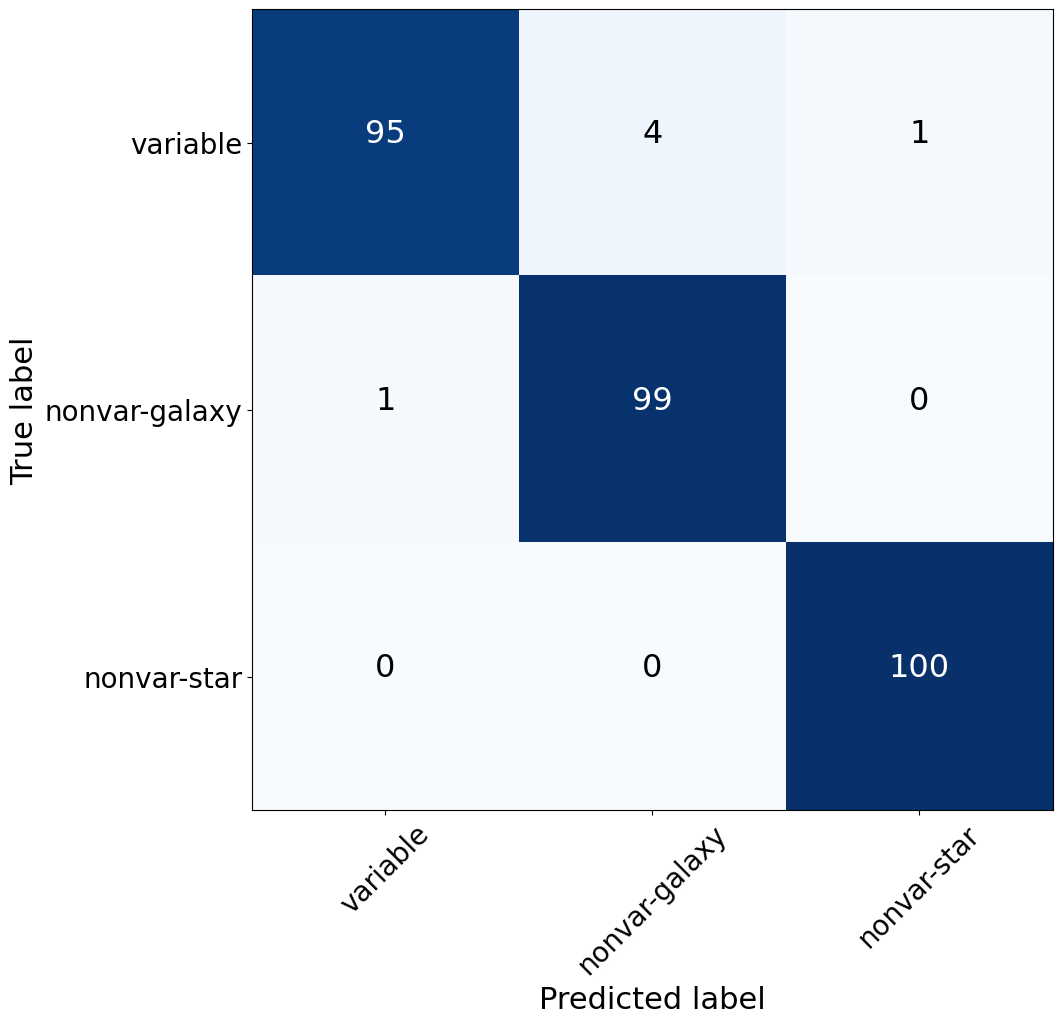

In [18]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_init)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_init,'plots_2023/training_conf_matrix_init_level_'+band+'band_zsep.pdf')

ps_score & 0.302
ips1-W2 & 0.160
W1-W2 & 0.065
ips1-W1 & 0.057
GP_DRW_sigma & 0.048
Psi_eta & 0.035
PPE & 0.032
rps1-W2 & 0.030
Meanvariance & 0.027
Q31 & 0.024
gps1-rps1 & 0.023
GP_DRW_tau & 0.017
Harmonics_mag_1 & 0.016
Eta_e & 0.016
SPM_chi & 0.016
gps1-W1 & 0.014
Autocor_length & 0.013
MedianAbsDev & 0.013
rps1-ips1 & 0.012
ExcessVar & 0.006
Std & 0.006
rps1-W1 & 0.006
Rcs & 0.005
gps1-W2 & 0.005
Amplitude & 0.004
IAR_phi & 0.003
SPM_A & 0.003
Psi_CS & 0.002
Gskew & 0.002
Skew & 0.002


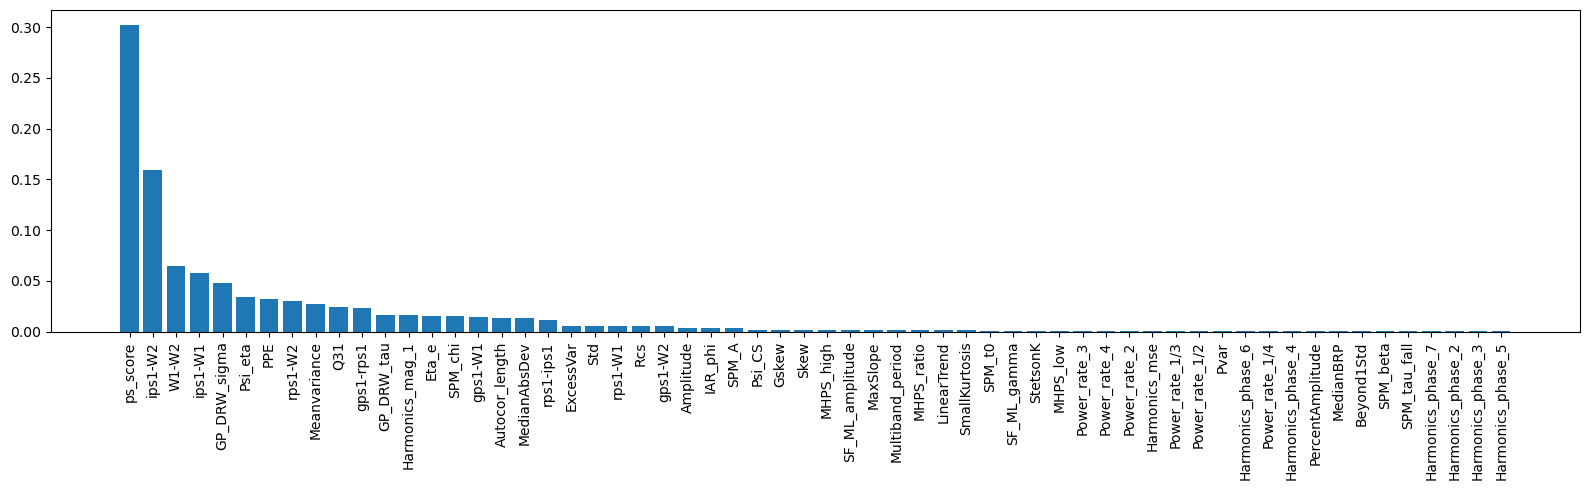

In [19]:
#plotting feature importance
plot_feature_importances(rf_model_init, features_init, 'plots_2023/training_feature_ranking_init_level_'+band+'band_zsep.pdf')

Counter({'Stochastic': 65219, 'Periodic': 21650, 'Transient': 401, 'nonvar-galaxy': 217, 'nonvar-star': 156})


Text(0.5, 1.0, 'sources classified as variable')

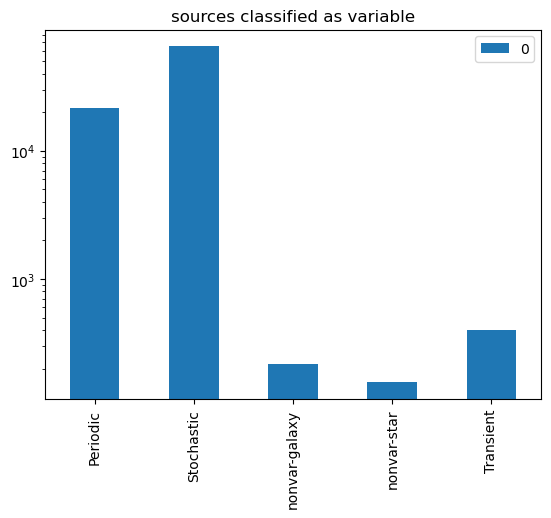

In [20]:
# separating classes (according to the predicted classification):

y_test_variable = y_test_variable.loc[y_pred=='variable']
X_test_variable =  X_test_init.loc[y_pred=='variable',:]

y_test_bottom_init = y_test_bottom.loc[y_pred=='variable']
X_test_bottom_init =  X_test_init.loc[y_pred=='variable',:]

letter_counts = Counter(y_test_variable)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as variable')

Counter({'nonvar-galaxy': 20209, 'lowz-AGN': 2454, 'midz-AGN': 370, 'SNIa': 222, 'SN-other': 110, 'Blazar': 81, 'YSO': 61, 'nonvar-star': 41, 'RRL': 37, 'highz-AGN': 30, 'EB/EW': 5, 'CV/Nova': 3, 'DSCT': 2, 'EA': 2, 'LPV': 1})


Text(0.5, 1.0, 'sources classified as nonvar-galaxy')

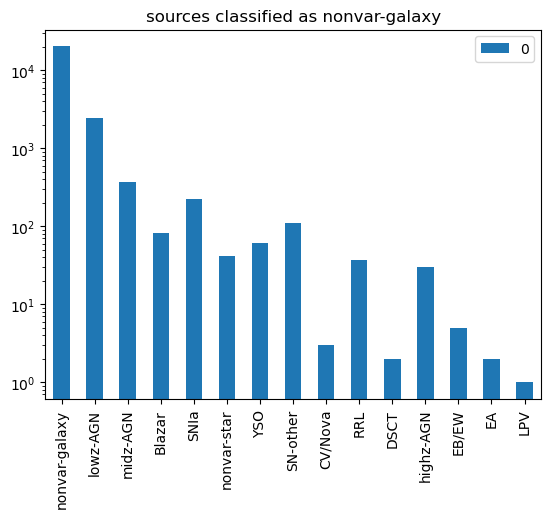

In [21]:

y_test_galaxy = y_test_bottom.loc[y_pred=='nonvar-galaxy']
X_test_galaxy = X_test_init.loc[y_pred=='nonvar-galaxy',:]

letter_counts = Counter(y_test_galaxy)
print(letter_counts)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as nonvar-galaxy')

Counter({'nonvar-star': 74917, 'YSO': 369, 'midz-AGN': 112, 'EB/EW': 68, 'RRL': 58, 'highz-AGN': 35, 'EA': 33, 'Periodic-other': 19, 'CV/Nova': 16, 'DSCT': 15, 'lowz-AGN': 10, 'nonvar-galaxy': 10, 'LPV': 10, 'Blazar': 2})


Text(0.5, 1.0, 'sources classified as nonvar-star')

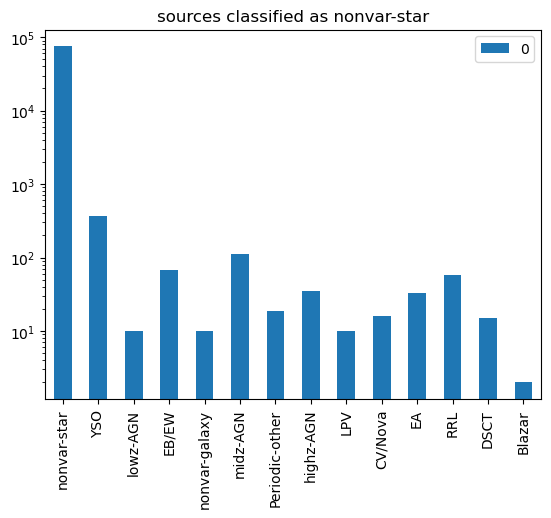

In [22]:
y_test_star = y_test_bottom.loc[y_pred=='nonvar-star']
X_test_star = X_test_init.loc[y_pred=='nonvar-star',:]

letter_counts = Counter(y_test_star)
print(letter_counts)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as nonvar-star')

 ### Variable level

In [23]:
#Training variable level

rf_model_variable = RandomForestClassifier(
            n_estimators=500,
            max_features=0.4,
            max_depth=70,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_variable.fit(X_train_variable, y_train_variable)


#testing variable layer performance

y_true_variable, y_pred_variable = y_test_variable, rf_model_variable.predict(X_test_variable)

y_pred_proba_variable = rf_model_variable.predict_proba(X_test_variable)

print("Accuracy:", metrics.accuracy_score(y_true_variable, y_pred_variable))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_variable, y_pred_variable))

classes_order_proba_variable = rf_model_variable.classes_
print(classes_order_proba_variable)


#Dumping trained model

features_variable = list(X_train_variable)

with open(model_variable_layer, 'wb') as f:
            pickle.dump(
                rf_model_variable,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.9816756614903643
Balanced accuracy: 0.5858339414252981
['Periodic' 'Stochastic' 'Transient']


[[  383     2    16]
 [  502 64241   476]
 [  195    42 21413]]
Normalized confusion matrix
[[96.  0.  4.]
 [ 1. 99.  1.]
 [ 1.  0. 99.]]


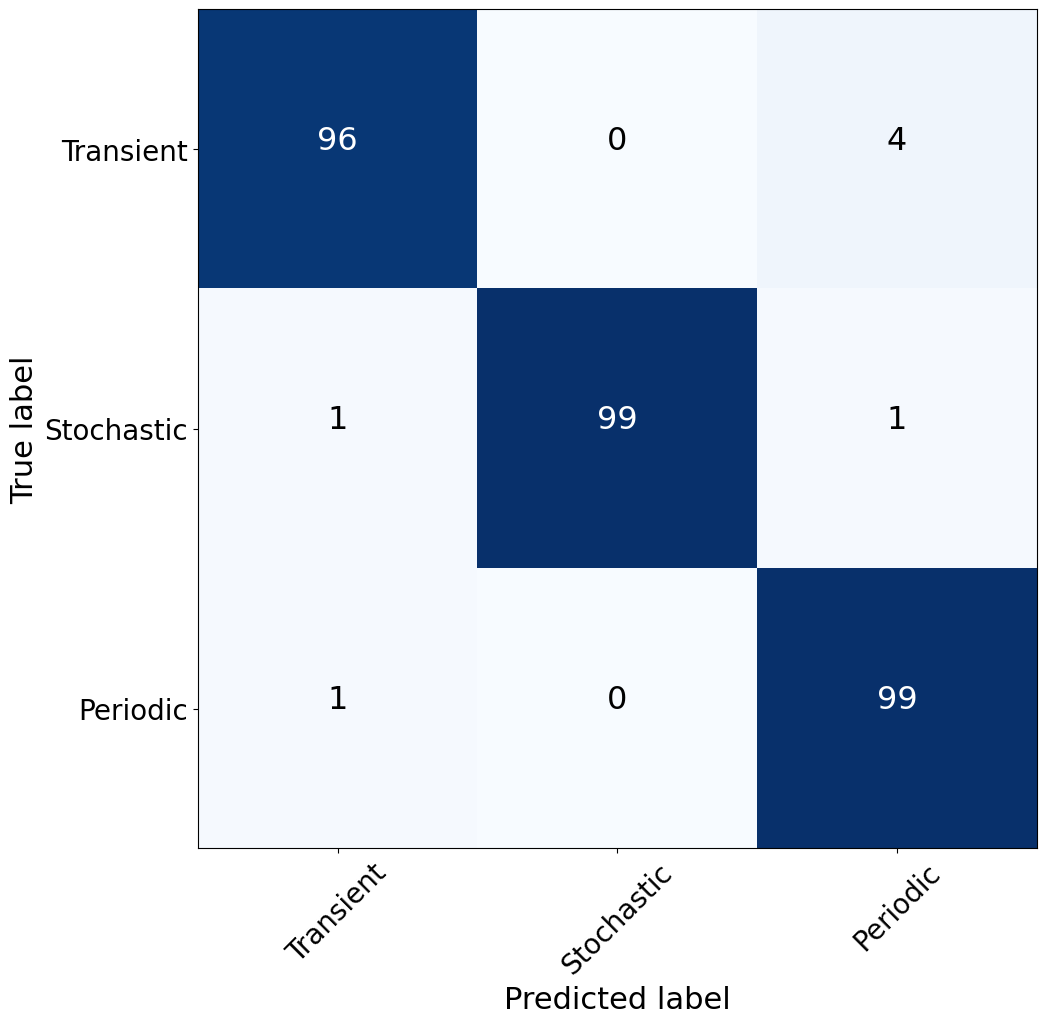

In [24]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_variable, y_pred_variable, labels=cm_classes_variable)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_variable,'plots_2023/training_conf_matrix_variable_level_'+band+'band_zsep.pdf')

W1-W2 & 0.244
SPM_chi & 0.140
Psi_eta & 0.081
ps_score & 0.068
SPM_A & 0.051
Eta_e & 0.039
ips1-W2 & 0.035
Harmonics_mse & 0.034
gps1-W2 & 0.021
gps1-W1 & 0.020
rps1-ips1 & 0.019
rps1-W2 & 0.019
gps1-rps1 & 0.019
Amplitude & 0.017
PPE & 0.015
IAR_phi & 0.014
GP_DRW_tau & 0.010
Psi_CS & 0.008
MHPS_high & 0.008
MHPS_low & 0.008
Std & 0.008
ExcessVar & 0.007
ips1-W1 & 0.006
MHPS_ratio & 0.006
PercentAmplitude & 0.005
rps1-W1 & 0.005
Skew & 0.005
GP_DRW_sigma & 0.005
Gskew & 0.005
Meanvariance & 0.004


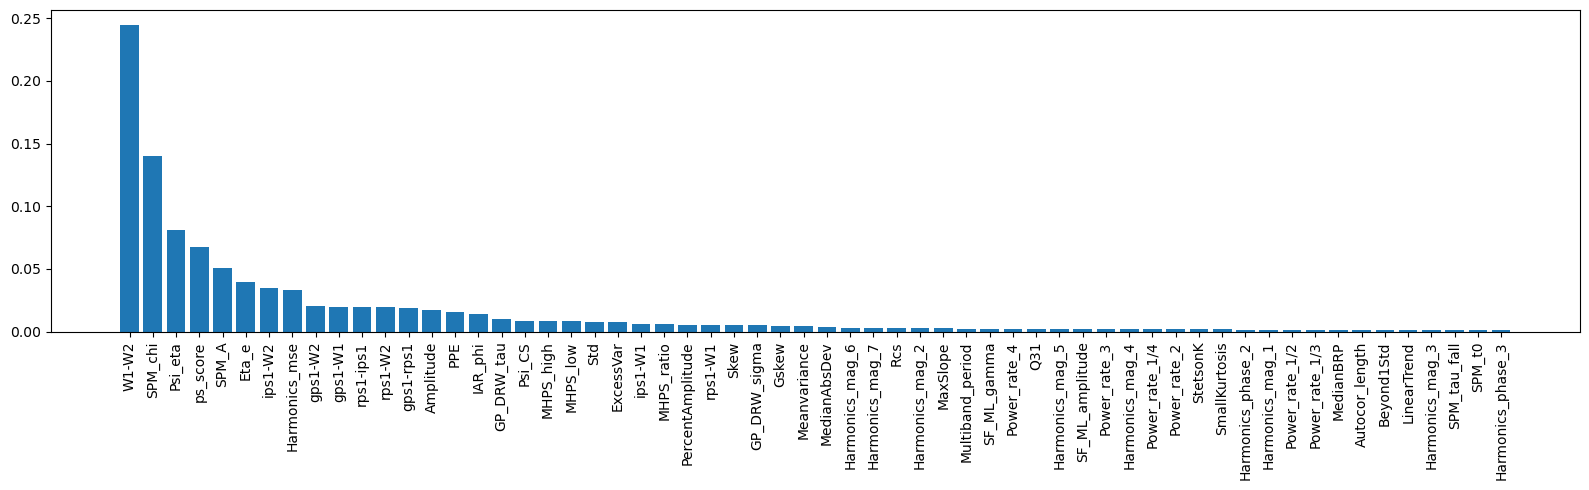

In [25]:
#plotting feature importance
plot_feature_importances(rf_model_variable, features_variable, 'plots_2023/training_feature_ranking_variable_level_'+band+'band_zsep.pdf')


## separating classes (according to the predicted classification):



Counter({'LPV': 6901, 'RRL': 6265, 'EB/EW': 6239, 'EA': 1423, 'YSO': 452, 'Periodic-other': 316, 'DSCT': 161, 'CEP': 108, 'nonvar-star': 37, 'CV/Nova': 16, 'lowz-AGN': 15, 'midz-AGN': 7, 'Blazar': 2, 'nonvar-galaxy': 2})


Text(0.5, 1.0, 'sources classified as periodic')

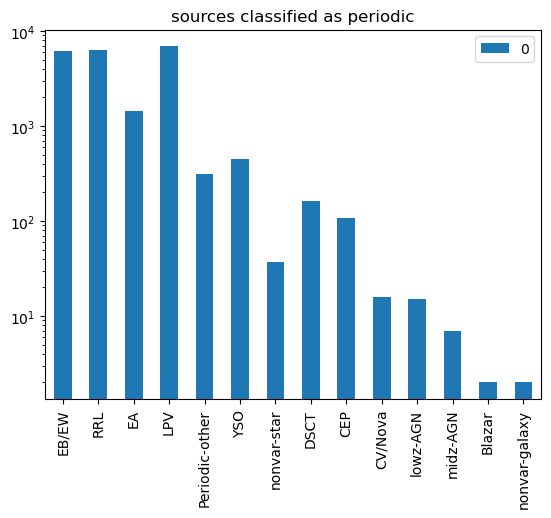

In [26]:
#Periodics

y_test_periodic = y_test_bottom_init.loc[y_pred_variable=='Periodic']
X_test_periodic =  X_test_bottom_init.loc[y_pred_variable=='Periodic',:]

letter_counts = Counter(y_test_periodic)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as periodic')

Counter({'midz-AGN': 55242, 'lowz-AGN': 4186, 'highz-AGN': 3049, 'YSO': 1568, 'Blazar': 196, 'nonvar-galaxy': 192, 'nonvar-star': 65, 'RRL': 22, 'LPV': 12, 'EB/EW': 5, 'Periodic-other': 2, 'CV/Nova': 1, 'DSCT': 1, 'SN-other': 1})


Text(0.5, 1.0, 'sources classified as stochastic')

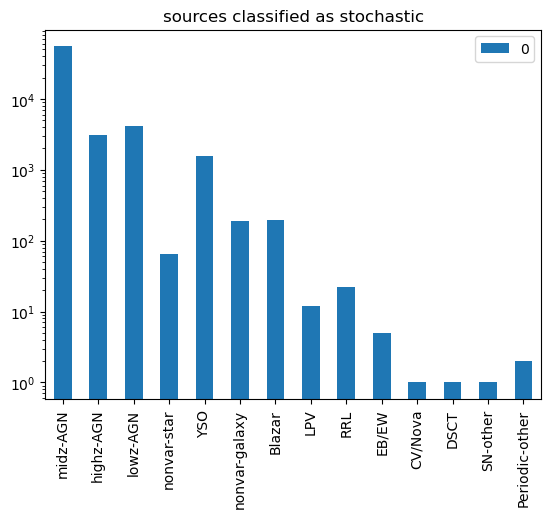

In [27]:
#Stochastics

y_test_stochastic = y_test_bottom_init.loc[y_pred_variable=='Stochastic']
X_test_stochastic =  X_test_bottom_init.loc[y_pred_variable=='Stochastic',:]

letter_counts = Counter(y_test_stochastic)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as stochastic')

Counter({'YSO': 194, 'midz-AGN': 189, 'SNIa': 164, 'CV/Nova': 144, 'RRL': 124, 'SN-other': 75, 'nonvar-star': 54, 'lowz-AGN': 43, 'Blazar': 41, 'highz-AGN': 35, 'EB/EW': 24, 'nonvar-galaxy': 23, 'EA': 22, 'LPV': 19, 'Periodic-other': 5, 'DSCT': 1})


Text(0.5, 1.0, 'sources classified as transient')

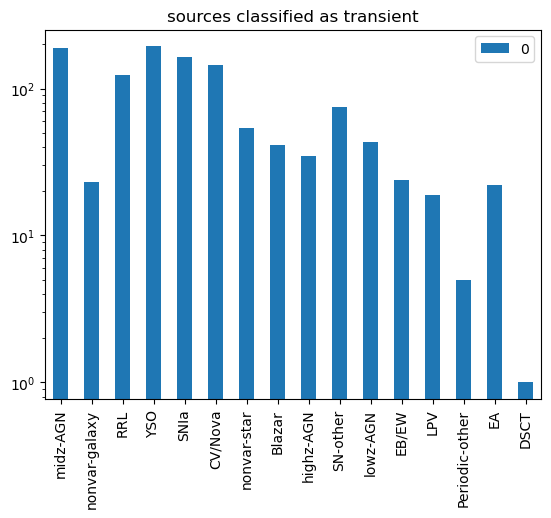

In [28]:
#Transients

y_test_transient = y_test_bottom_init.loc[y_pred_variable=='Transient']
X_test_transient =  X_test_bottom_init.loc[y_pred_variable=='Transient',:]

letter_counts = Counter(y_test_transient)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as transient')

   ### Periodic model

In [29]:
#Training periodic level

rf_model_periodic = RandomForestClassifier(
            n_estimators=400,
            max_features=0.4,
            max_depth=50,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


#testing periodic layer performance

y_true_periodic, y_pred_periodic = y_test_periodic, rf_model_periodic.predict(X_test_periodic)

y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

print("Accuracy:", metrics.accuracy_score(y_true_periodic, y_pred_periodic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_periodic, y_pred_periodic))

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)


#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.8888990156762668
Balanced accuracy: 0.4409621458060789
['CEP' 'DSCT' 'EA' 'EB/EW' 'LPV' 'Periodic-other' 'RRL']


[[6846    5    0    2    2   42    4]
 [   1 1317   55    6   11   10   23]
 [   1  398 5163  223  100   32  322]
 [   1    1    5  152    0    0    2]
 [  10   26  143   69 5704  241   72]
 [   2    1    1    2    5   90    7]
 [   3    9   41    8    8   13  234]]
Normalized confusion matrix
[[99.  0.  0.  0.  0.  1.  0.]
 [ 0. 93.  4.  0.  1.  1.  2.]
 [ 0.  6. 83.  4.  2.  1.  5.]
 [ 1.  1.  3. 94.  0.  0.  1.]
 [ 0.  0.  2.  1. 91.  4.  1.]
 [ 2.  1.  1.  2.  5. 83.  6.]
 [ 1.  3. 13.  3.  3.  4. 74.]]


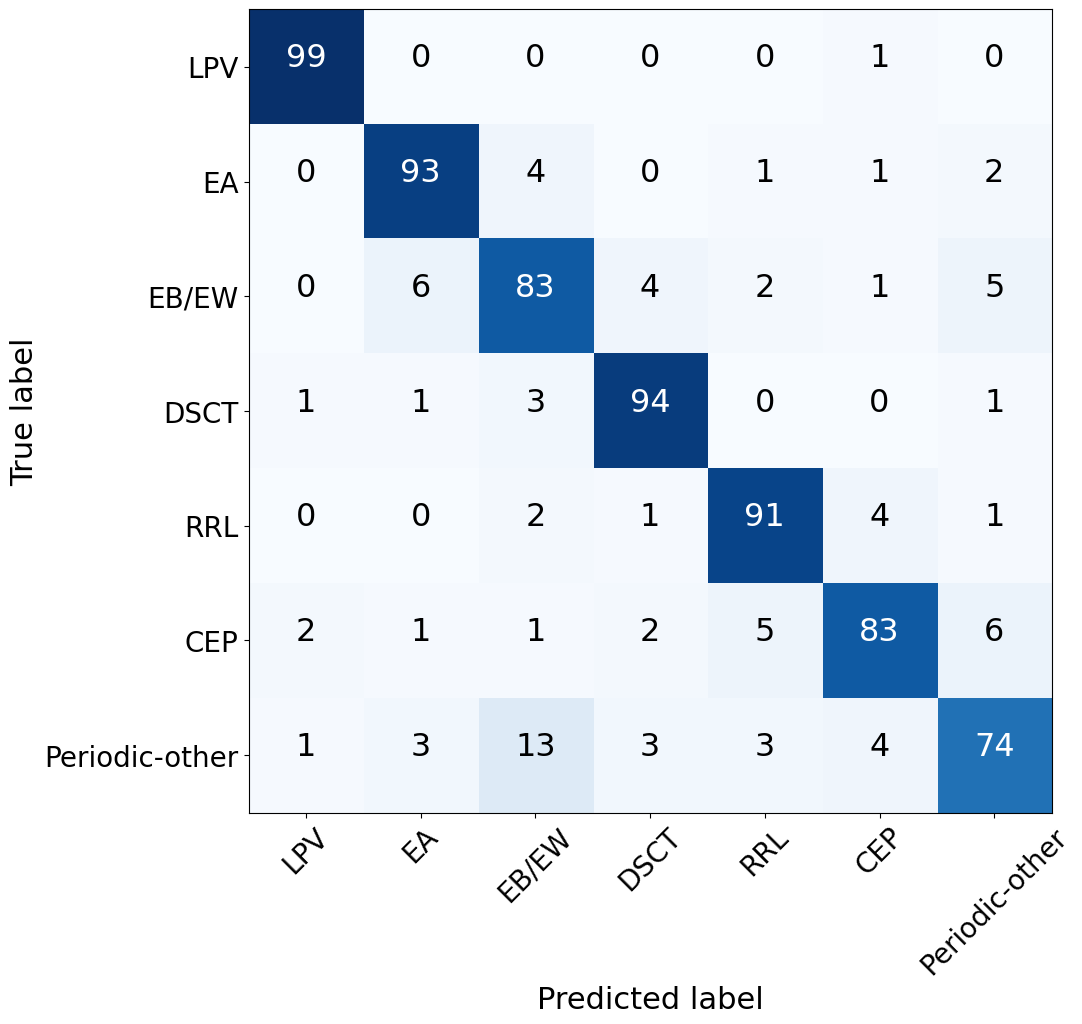

In [30]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_periodic, y_pred_periodic, labels=cm_classes_periodic)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_periodic,'plots_2023/training_conf_matrix_periodic_level_'+band+'band_zsep.pdf')

Multiband_period & 0.199
Skew & 0.088
Gskew & 0.058
gps1-W1 & 0.049
GP_DRW_tau & 0.037
MHPS_ratio & 0.028
gps1-W2 & 0.025
ips1-W1 & 0.025
IAR_phi & 0.024
ips1-W2 & 0.023
Beyond1Std & 0.023
rps1-W1 & 0.021
MedianBRP & 0.020
SPM_chi & 0.017
MedianAbsDev & 0.016
GP_DRW_sigma & 0.016
Meanvariance & 0.014
rps1-W2 & 0.013
ExcessVar & 0.012
Q31 & 0.012
PPE & 0.011
Harmonics_mag_1 & 0.011
rps1-ips1 & 0.010
gps1-rps1 & 0.010
StetsonK & 0.010
Psi_eta & 0.010
SPM_A & 0.009
Harmonics_phase_2 & 0.009
SmallKurtosis & 0.009
Std & 0.009


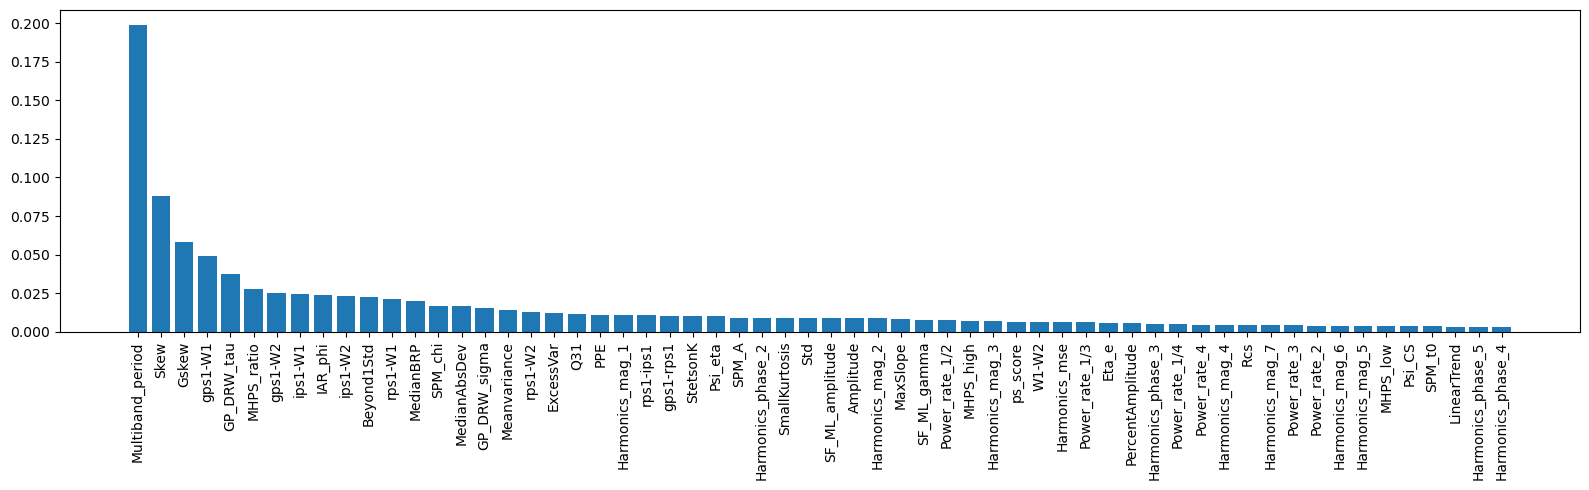

In [31]:
#plotting feature importance
plot_feature_importances(rf_model_periodic, features_periodic, 'plots_2023/training_feature_ranking_periodic_level_'+band+'band_zsep.pdf')



### Stochastic model

In [ ]:
#Training stochastic level

rf_model_stochastic = RandomForestClassifier(
            n_estimators=200,
            max_features=0.4,
            max_depth=70,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


#testing stochastic layer performance

y_true_stochastic, y_pred_stochastic = y_test_stochastic, rf_model_stochastic.predict(X_test_stochastic)

y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

print("Accuracy:", metrics.accuracy_score(y_true_stochastic, y_pred_stochastic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_stochastic, y_pred_stochastic))

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)


#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

In [ ]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_stochastic, y_pred_stochastic, labels=cm_classes_stochastic)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_stochastic,'plots_2023/training_conf_matrix_stochastic_level_'+band+'band_zsep.pdf')

In [ ]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'plots_2023/training_feature_ranking_stochastic_level_'+band+'band_zsep.pdf')



### Transient model

In [ ]:
#Training transient level

rf_model_transient = RandomForestClassifier(
            n_estimators=200,
            max_features='auto',
            max_depth=10,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)


#testing transient layer performance

y_true_transient, y_pred_transient = y_test_transient, rf_model_transient.predict(X_test_transient)

y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

print("Accuracy:", metrics.accuracy_score(y_true_transient, y_pred_transient))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_transient, y_pred_transient))

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)


#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

In [ ]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_transient, y_pred_transient, labels=cm_classes_transient)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_transient,'plots_2023/training_conf_matrix_transient_level_'+band+'band_zsep.pdf')

In [ ]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'plots_2023/training_feature_ranking_transient_level_zsep.pdf')



## Putting all together 

In [ ]:
# generating confusion matrix for multilabels



y_true_bottom = np.concatenate((y_true_stochastic,y_true_periodic,y_true_transient,y_test_bottom.loc[y_pred!='variable']))
y_pred_bottom = np.concatenate((y_pred_stochastic,y_pred_periodic,y_pred_transient,y_pred[np.where(y_pred!='variable')]))

cnf_matrix = metrics.confusion_matrix(y_true_bottom, y_pred_bottom,labels=cm_classes_original)
print(cnf_matrix)
plot_confusion_matrix_all(cnf_matrix,cm_classes_original, 'plots_2023/training_conf_matrix_bottom_level_'+band+'band_zsep.pdf')

print("Accuracy:", metrics.accuracy_score(y_true_bottom, y_pred_bottom))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_bottom, y_pred_bottom))

In [ ]:
print(metrics.classification_report(y_true_bottom, y_pred_bottom, target_names=np.unique(y_true_bottom)))

In [ ]:
np.unique(y_true_bottom)

In [ ]:
print(metrics.classification_report(y_true_bottom, y_pred_bottom,labels=cm_classes_original))

In [ ]:
y_true_bottom_agn = y_true_bottom
y_pred_bottom_agn = y_pred_bottom

y_true_bottom_agn[np.where((y_true_bottom_agn=="lowz-AGN") | (y_true_bottom_agn=="midz-AGN") | (y_true_bottom_agn=="highz-AGN") | (y_true_bottom_agn=="Blazar"))]='AGN'
y_pred_bottom_agn[np.where((y_pred_bottom_agn=='lowz-AGN') | (y_pred_bottom_agn=='midz-AGN') | (y_pred_bottom_agn=='highz-AGN') | (y_pred_bottom_agn=='Blazar'))]='AGN'

label_order_agn = ['SNIa','SN-other','CV/Nova','AGN', 'YSO',
               'LPV', 'EA', 'EB/EW', 'DSCT', 'RRL', 'CEP', 'Periodic-other',
               'nonvar-galaxy','nonvar-star']

In [ ]:
print(metrics.classification_report(y_true_bottom_agn, y_pred_bottom_agn,labels=label_order_agn))

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_true_bottom_agn, y_pred_bottom_agn,labels=label_order_agn)
print(cnf_matrix)
plot_confusion_matrix_all(cnf_matrix,label_order_agn, 'plots_2023/training_conf_matrix_bottom_level_'+band+'band_zsep_AGN_grouped.pdf')

print("Accuracy:", metrics.accuracy_score(y_true_bottom, y_pred_bottom))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_bottom, y_pred_bottom))